# Problem Set 3 - Thomas Vandal

In [1]:
# all imports needed in the problem set
import numpy as np

from cmb_methods import get_spectrum  # method to compute CMB power spectrum with CAMB
import plots as pl                    # plotting methods useful for the assignment
import opt_methods as om              # all optimization/sampling methods

## Problem 1
Here I use a slightly modified version of the [example script](https://github.com/sievers/phys512/blob/master/problem_sets/wmap_camb_example.py). The [get\_spectrum method](https://github.com/tomvandal/phys512/blob/master/assignments/ps3/cmb_methods.py) calculates the CMB power spectrum for a given set of parameters $H_0$,$\omega_b h^2$, $\omega_c h^2$, $\tau$, $A_s$, and $n_s$. The other two parameters define the maximum multipole indices used for accuracy, and for the returned spectrum (these two are fixed for the whole problem set). Note that this method does not return the first two multipole indices since they are not included in the WMAP data.

In the next cell, I use the guess values proposed in the problem set, generate a model, calculate $\chi^2$, and plot it.

Guess Params.: H0=65.0, ombh2=0.02, omch2=0.1, tau=0.05, As=2e-09, ns=0.96
Chi2: 1588.2376458618892


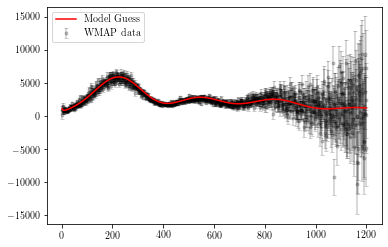

In [2]:
# load WMAP data
# I assume the errror on the power to be Gaussian, uncorrelated
wmap_data = np.loadtxt("wmap_tt_spectrum_9yr_v5.txt")
index, power, epower = wmap_data[:, 0], wmap_data[:, 1], wmap_data[:, 2]

# parameter values guess
pguess = np.array([65.0, 0.02, 0.1, 0.05, 2e-9, 0.96])

# get CAMB model for given parameters
cmb = get_spectrum(pguess)  # , lmax_ret=int(index.max()))

# calculate chi2 for the cmb powers
chi2 = np.sum(((power - cmb)/epower)**2)

# print results
pstr = ("Guess Params.: "
        "H0={}, ombh2={}, omch2={}, tau={}, As={}, ns={}".format(*pguess))
chi2str = "Chi2: {}".format(chi2)
print(pstr)
print(chi2str)  # value is around 1588, as expected

# plot of spectrum and data
pl.spectrum(index, power, epower=epower, ind_fit=index, power_fit=cmb,
            fit_label="Model Guess")


As we see above $\chi^2$ is around 1588, as expected, and the model appears to be reasonable when we look at the plot.

## Problem 2
### LMA Optimizer
The Levenberg-Marquardt algorithm (LMA) used in this problem can be found in [opt\_methods](https://github.com/tomvandal/phys512/blob/master/assignments/ps3/opt_methods.py). It takes a function, a method to compute the gradient, a dataset, and an initial guess of the parameters as an input.

### Gradient method
The function I optimize here is a wrapper for get\_spectrum where $\tau$ is treated as a constant. To compute the gradient with respect to parameters, I use a one-sided first order difference, where the step size is set to 1/1000 of each parameter. Using a one-sided differentiator instead of central difference allows to minimize the number of (time consuming) function evaluations of get\_spectrum. **The performance of this differentiator is discussed below** (after the parameters are optimized).

Initial parameters: [6.5e+01 2.0e-02 1.0e-01 2.0e-09 9.6e-01]
Initial Chi2: 1588.2376458618892

Starting optimization...
Params for step 1: [6.78114142e+01 2.24452502e-02 1.15032013e-01 2.05936949e-09
 9.67242631e-01]
Chi2: 1233.608682705431

Params for step 2: [6.92728764e+01 2.24940507e-02 1.14064843e-01 2.04373812e-09
 9.69728372e-01]
Chi2: 1227.936930936154

Params for step 3: [6.93353214e+01 2.24925037e-02 1.13895514e-01 2.04240637e-09
 9.69802311e-01]
Chi2: 1227.9356533320401

Params for step 4: [6.93283537e+01 2.24917377e-02 1.13910416e-01 2.04249902e-09
 9.69777637e-01]
Chi2: 1227.935635383898
The Newton Method converged after 3 iterations
The optimization took 4.799642829100291 minutes

Optimized parameters: [6.93353214e+01 2.24925037e-02 1.13895514e-01 2.04240637e-09
 9.69802311e-01]
Errors [2.40402622e+00 5.40988200e-04 5.23086517e-03 3.90084548e-11
 1.35987484e-02]

Optimized Parameters:
  Ho = 69.3353 +/- 3.6720
  ombh2 = 0.0225 +/- 0.0009
  omch2 = 0.1139 +/- 0.0070
  tau

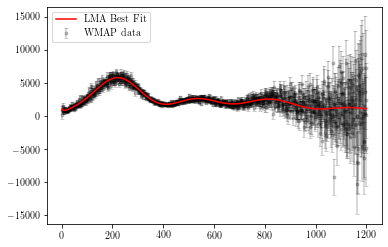

In [3]:
def get_spec(p, tau=0.05):
    """ Get power spectrum with fixed tau

    Wrapper for get_spectrum with tau fixed and excluded from parameter array
    """
    p = np.insert(p, 3, tau)
    return get_spectrum(p)


# parameter values guess
pguess = np.array([65.0, 0.02, 0.1, 0.05, 2e-9, 0.96])

# optimization
pguess_short = np.append(pguess[:3], pguess[4:])
tauguess = pguess[3]
p, cov = om.lma_opt(get_spec, om.grad_diff1, index, power, epower,
                    pguess_short, maxit=10, tol=1e-3, lamb_init=0.001,
                    dp_grad=None)
print("Optimized parameters:", p)
print("Errors", np.sqrt(np.diag(cov)))
print()

# final params and cov (with tau)
# I now include tau in the parameter array and calculate the curvature (and then the covariance matrix)
# with tau, to have a complete covariance matrix to use with our MCMC in the next problems.
popt = np.insert(p, 3, tauguess)
pcov = om.get_cov(epower, popt, get_spectrum, om.grad_diff1)  # see opt_methods.py for get_cov details
pnames = ["Ho", "ombh2", "omch2", "tau", "As", "ns"]
print("Optimized Parameters:")
for i in range(len(popt)):
    if i == 4:
        print("  {} = {:.4f} +/- {:.4f}".format(pnames[i]+" x 10^9",
                                        popt[i]*10**9,
                                        np.sqrt(np.diag(pcov))[i]*10**9))
    else:
        print("  {} = {:.4f} +/- {:.4f}".format(pnames[i],
                                        popt[i],
                                        np.sqrt(np.diag(pcov))[i]))
print()
# save results to avoid running the optimizer everytime I use the optimized params or cov
np.savetxt("opt_params.txt", popt)  # save results
np.savetxt("opt_cov.txt", pcov)

# show the final covariance matrix with tau included
print("Final Covariance Matrix:")
print(pcov)

# plot final result
cmb_fit_opt = get_spectrum(popt)
chi2_opt = np.sum(((power - cmb_fit_opt)/epower)**2)
pl.spectrum(index, power, epower=epower, ind_fit=index, power_fit=cmb_fit_opt,
            fit_label="LMA Best Fit")


As we see above, **the gradient method with respect to parameters seems to be working fine since the steps taken in parameter space lead to a lower $\chi^2$**

**If we were allowing $\tau$ to vary with the other parameters,** this would add a dimension to the parameter space. The error of parameters that have no correlation with $\tau$ should not be affected, since the way they vary would not depend on $\tau$. However, for parameters that are strongly correlated with $\tau$, it is possible that varying $\tau$ would allow to explore new values and that the curvature at these new values is different. If the curvature is bigger (clearer peak) the, variance would be smaller and vice-versa. However, the high error on $\tau$ shown above shows that it is poorly constrained by the data so it might lower its overall effect on the other parameters.

## Summary of MCMC scripts and methods
### MCMC sampling script
The MCMC sampling method used in this problem set is mcmc from opt\_methods.py. Since the MCMC takes a lot of time to converge, I did not run it in this notebook, but I used the [run\_mcmc](https://github.com/tomvandal/phys512/blob/master/assignments/ps3/run_mcmc.py) file instead. This script loads the optimization results (problem 2), uses the covariance matrix to draw samples from a proposal distribution, and maximizes the log-likelihood. It can save the chains in a text file that can be used to manipulate the chains in a separate script. I also saved four plots: the chains vs the steps, a corner plot, the Fourier transform of each chain, and the model. These plots are also shown below. **The 50th percentile is kept as the final value and the 16th and 84th percentiles give the + and - errors.**. This script can be used for problems 3 and 4.

### MCMC method details
For the MCMC, instead of minimizing $\chi^2$, I maximized the log of the posterior probability, so I needed the log-likelihood (LL) and possibly some priors. The acceptance/rejection condition for each step is equivalent to what we saw in class. The proposal distribution can be changed, but here I always use the covariance matrix to draw samples.

## Problem 3
For this problem, I used the MCMC methods described above to run and save the chains in the [mcmc3 folder](https://github.com/tomvandal/phys512/blob/master/assignments/ps3/mcmc3). The resulting chains are plotted and analyzed below.

### Postive $\tau$ prior
To keep $\tau$ postive, I used a prior that made the posterior probability 0 ($\ln(p)=-\infty$) when $\tau$ is negative (see $\texttt{logpost\_postau}$ in $\texttt{run\_mcmc.py}$). Otherwise the logarithmic probability is just the LL value.


### Analysis of the chains
The cell below shows the analysis of the chains. The positive $\tau$ prior is used. A burn in of 1000 steps is used to remove a clear trend at the begining of the chain. To evaluate the convergence, the Fourier transform of each chain is shown. The results are discussed after they next cell. I used a scale factor of 0.5 for problem 3.

The chain has 9000 steps
Acceptance ratio: 0.25277777777777777


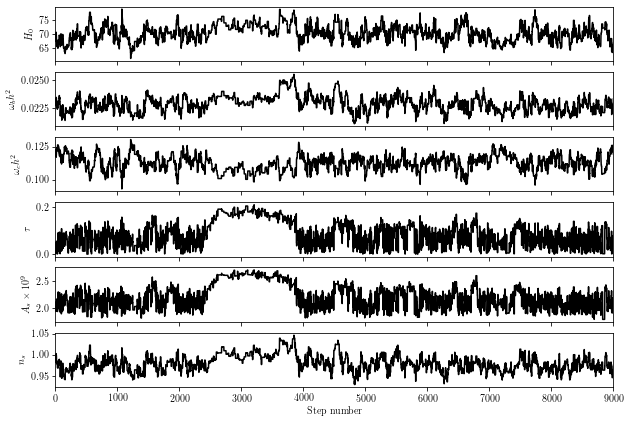

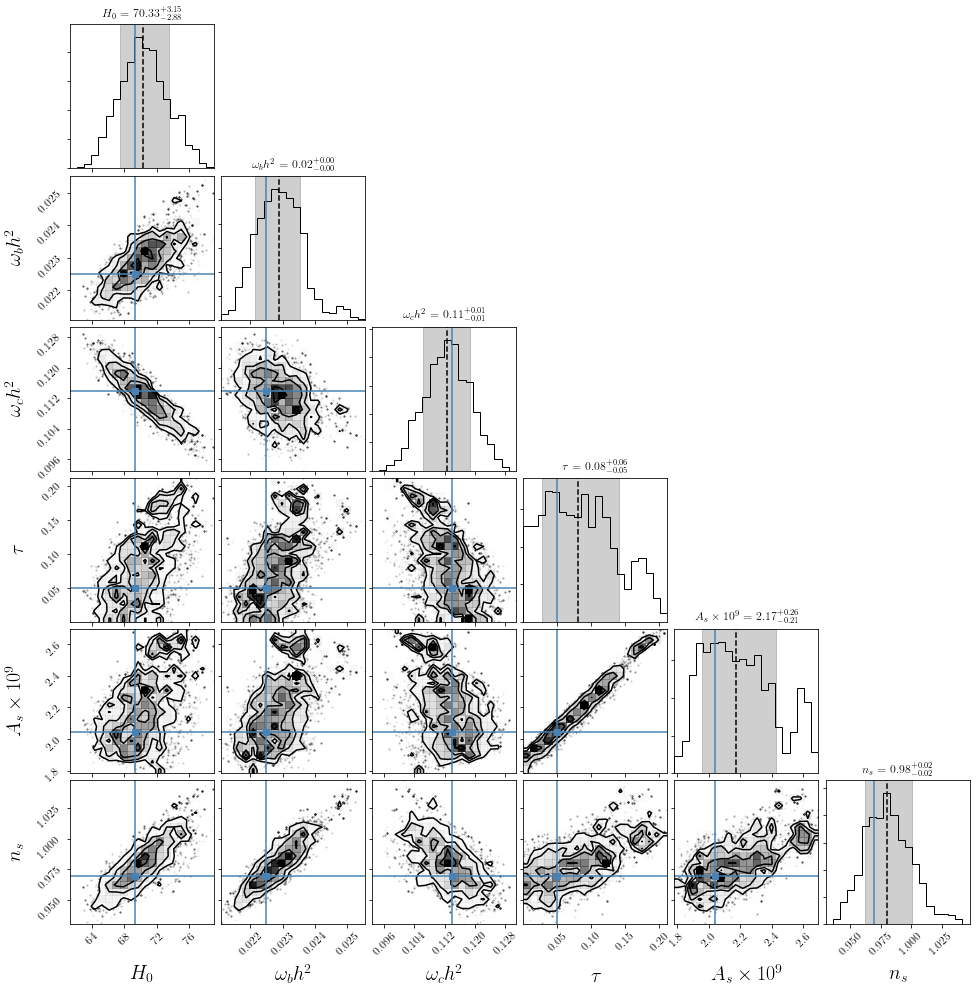

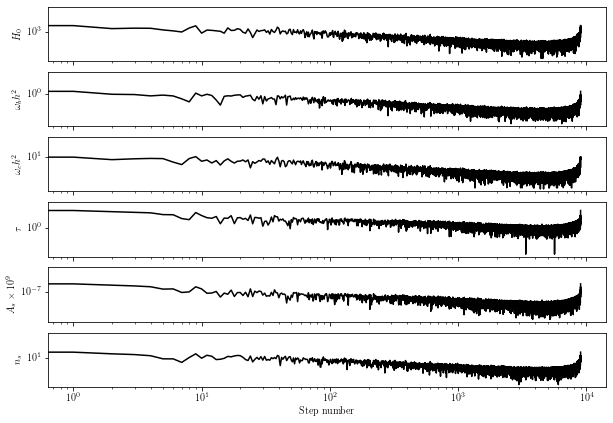

LMA Parameters:
  Ho = 69.3353 +/- 3.6720
  ombh2 = 0.0225 +/- 0.0009
  omch2 = 0.1139 +/- 0.0070
  tau = 0.0500 +/- 0.1493
  As x 10^9 = 2.0424 +/- 0.5933
  ns = 0.9698 +/- 0.0262
Chi2: 1227.9356533320401

MCMC parameters:
  Ho = 70.3293 + 3.1481 - 2.8772
  ombh2 = 0.0229 + 0.0007 - 0.0007
  omch2 = 0.1127 + 0.0060 - 0.0064
  tau = 0.0811 + 0.0602 - 0.0528
  As x 10^9 = 2.1725 + 0.2568 - 0.2113
  ns = 0.9800 + 0.0206 - 0.0175
Chi2: 1228.1665665179776


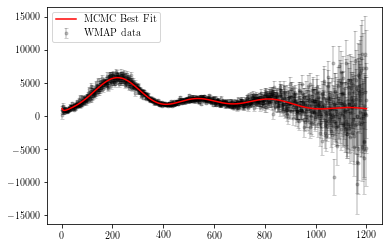

In [4]:
# load opt results
popt = np.loadtxt("opt_params.txt")
pcov = np.loadtxt("opt_cov.txt")
popt_err = np.sqrt(np.diag(pcov))

# tunable parameters
chainsdir = "mcmc3/"
save = True  # save the plots if true
addburn = 1000  # 1000 burn in steps since chains had a clear trend before that

# load chains
chains = np.loadtxt(chainsdir+"chains.txt")
chains = chains[addburn:]  # remove extra burn in
nsteps = chains.shape[0]
print("The chain has {} steps".format(nsteps))

# get acceptance fraction (everytime diff is 0, step rejected)
chains_diff = np.diff(chains, axis=0)
acc_ratio = float(np.count_nonzero(chains_diff, axis=0)[0])/nsteps
print("Acceptance ratio:", acc_ratio)

# plot of chains
plotchains = chains.copy()
plotchains[:, 4] *= 1e9  # make As readable on plots
ptrue = popt.copy()
ptrue[4] *= 1e9
plabels = [r"$H_0$", r"$\omega_b h^2$", r"$\omega_c h^2$", r"$\tau$",
           r"$A_s \times 10^9$", r"$n_s$"]
pl.mcmc_chains(np.array([plotchains]), plabels,
               savepath=chainsdir+"chains.png" if save else None, show=True)
pl.mcmc_corner(plotchains, plabels, truths=ptrue, ticksize=12,
               label_kwargs={"fontsize": 20},
               savepath=chainsdir+"corner.png" if save else None, show=True)

# check convergence with FFT
ft = np.abs(np.fft.fft(chains, axis=0))
pl.mcmc_chains(np.array([ft]), plabels, show=True,
               savepath=chainsdir+"ft.png" if save else None,
               scale="log", lim=False)

# final model
pvals3 = np.median(chains, axis=0)  # get median for each param
perr3_hi = np.percentile(chains, 84, axis=0) - pvals3
perr3_lo = pvals3 - np.percentile(chains, 16, axis=0)
perr3 = np.mean([perr3_hi, perr3_lo])
# print opt result
pnames = ["Ho", "ombh2", "omch2", "tau", "As", "ns"]
print("LMA Parameters:")
for i in range(len(popt)):
    if i == 4:
        print("  {} = {:.4f} +/- {:.4f}".format(pnames[i]+" x 10^9",
                                        popt[i]*10**9,
                                        np.sqrt(np.diag(pcov))[i]*10**9))
    else:
        print("  {} = {:.4f} +/- {:.4f}".format(pnames[i],
                                        popt[i],
                                        np.sqrt(np.diag(pcov))[i]))
print("Chi2:", chi2_opt)
print()

# print MCMC result
print("MCMC parameters:")
for i in range(len(pvals3)):
    if i == 4:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i]+" x 10^9",
                                           pvals3[i]*10**9,
                                           perr3_hi[i]*10**9,
                                           perr3_lo[i]*10**9))
    else:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i],
                                           pvals3[i],
                                           perr3_hi[i],
                                           perr3_lo[i]))
cmb_fit_mcmc3 = get_spectrum(pvals3)
chi2_mcmc3 = np.sum(((power - cmb_fit_mcmc3)/epower)**2)
print("Chi2:", chi2_mcmc3)

# plot final model
pl.spectrum(index, power, epower=epower, ind_fit=index, power_fit=cmb_fit_mcmc3,
            fit_label="MCMC Best Fit",
            savepath=chainsdir+"fit.png" if save else None)


The final parameter values and unceratinties are given above. As we can see, they are all consistent with the LMA values within the uncertainties. We see that the error is slightly reduced in the MCMC compared to the LMA. This might come from the different methods used to calculate the error, or to the fact that $\tau$ was allowed to vary. The final $\chi^2$ is a bit higher than for the LMA optimizer, but reasonably close. As we see, for low k (large scales) the Fourier transform of the chains is approximately flat, so the chains seem to have converged. Also, the acceptance ratio of approximately 0.25 shows that the proposal distribution has an appropriate scale.

We see that, as expected from the LMA covariance, $\tau$ is poorly constrained. It also has a significant correlation with $A_S$ (the pattern is clear in the chains and confirmed by the corner plot).

## Problem 4
### New MCMC with prior on $\tau$
I first used the same method as in problem 3 to obtain chains with a Gaussian prior on $\tau$. To do this, I added the log of a Gaussian with $\mu=0.0544$, $\sigma=0.0073$ to the LL at each drawn value. That way, values that are closer to the Planck reported value will have higher chances of being accepted. I still kept the postive $\tau$ prior from problem 3 to ensure no negative values were allowed.

The chains for this problem are in the [mcmc4 folder](https://github.com/tomvandal/phys512/blob/master/assignments/ps3/mcmc4).

Note: since more $\tau$ values are rejected (because of the prior), I changed the scale factor of the proposal distribution to keep the acceptance rate around 0.25. The scale factor used for problem 4 was 0.25.

The resulting chains are shown below.

The chain has 9000 steps
Acceptance ratio: 0.20833333333333334


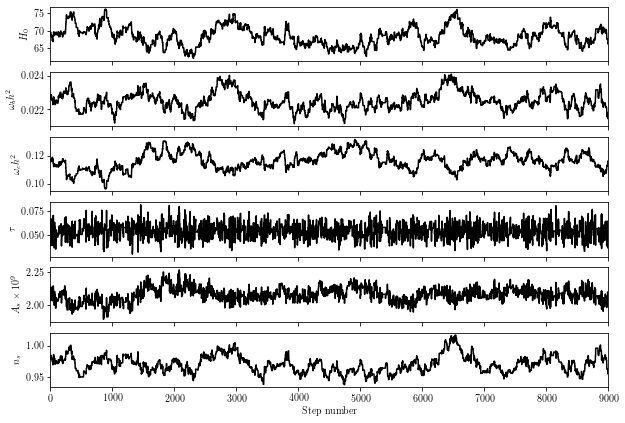

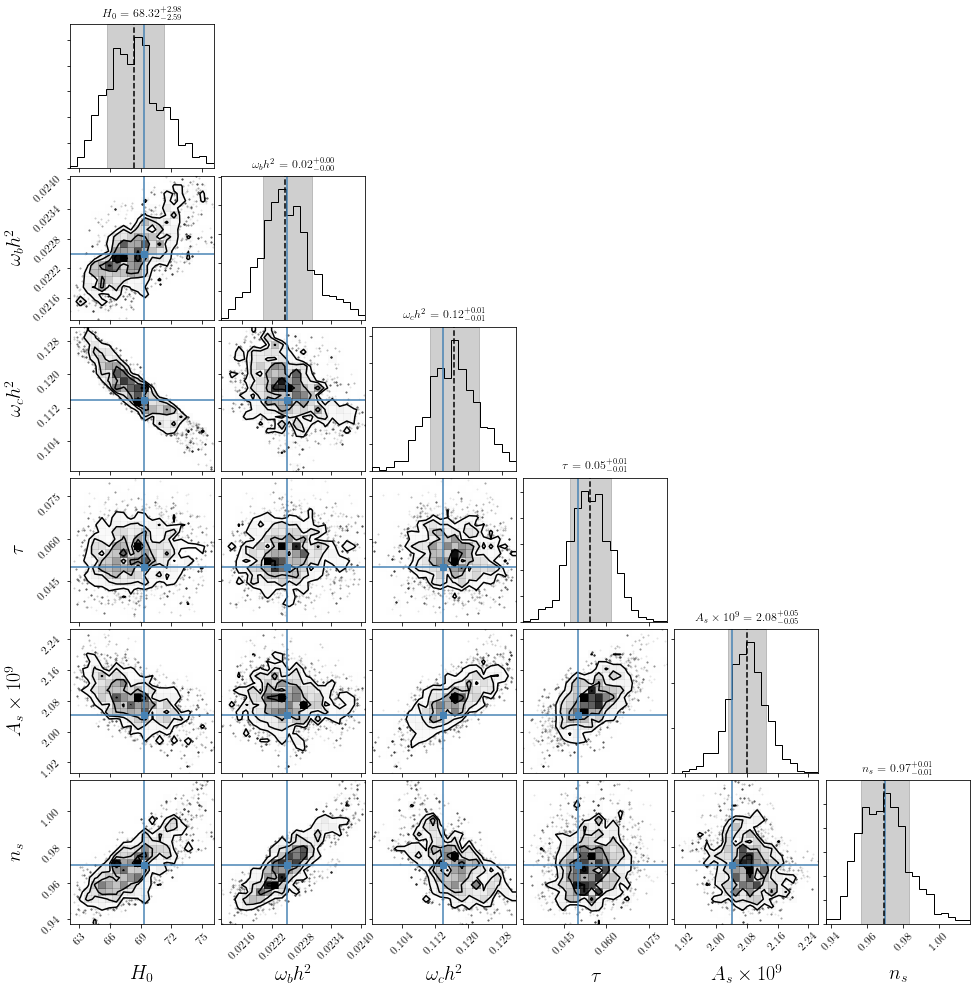

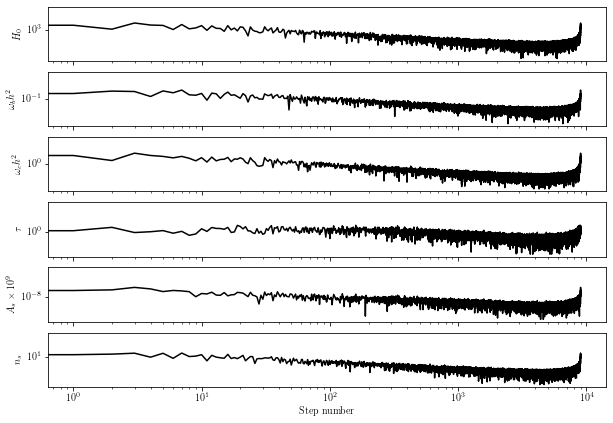

LMA Parameters:
  Ho = 69.3353 +/- 3.6720
  ombh2 = 0.0225 +/- 0.0009
  omch2 = 0.1139 +/- 0.0070
  tau = 0.0500 +/- 0.1493
  As x 10^9 = 2.0424 +/- 0.5933
  ns = 0.9698 +/- 0.0262
Chi2: 1227.9356533320401

MCMC (+ve tau) parameters:
  Ho = 70.3293 + 3.1481 - 2.8772
  ombh2 = 0.0229 + 0.0007 - 0.0007
  omch2 = 0.1127 + 0.0060 - 0.0064
  tau = 0.0811 + 0.0602 - 0.0528
  As x 10^9 = 2.1725 + 0.2568 - 0.2113
  ns = 0.9800 + 0.0206 - 0.0175
Chi2: 1228.1665665179776

MCMC (Gaussian prior) parameters:
  Ho = 68.3202 + 2.9767 - 2.5854
  ombh2 = 0.0225 + 0.0006 - 0.0004
  omch2 = 0.1165 + 0.0060 - 0.0058
  tau = 0.0542 + 0.0076 - 0.0069
  As x 10^9 = 2.0798 + 0.0488 - 0.0489
  ns = 0.9692 + 0.0138 - 0.0127
Chi2: 1228.2900950263747


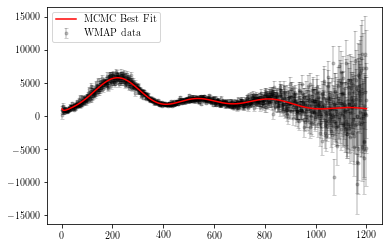

In [5]:
# load opt results
popt = np.loadtxt("opt_params.txt")
pcov = np.loadtxt("opt_cov.txt")
popt_err = np.sqrt(np.diag(pcov))

# tunable parameters
chainsdir = "mcmc4/"
save = True  # save the plots if true
addburn = 1000  # 1000 burn in steps since chains had a clear trend before that

# load chains
chains = np.loadtxt(chainsdir+"chains.txt")
chains = chains[addburn:]  # remove extra burn in
nsteps = chains.shape[0]
print("The chain has {} steps".format(nsteps))

# get acceptance fraction (everytime diff is 0, step rejected)
chains_diff = np.diff(chains, axis=0)
acc_ratio = float(np.count_nonzero(chains_diff, axis=0)[0])/nsteps
print("Acceptance ratio:", acc_ratio)

# plot of chains
plotchains = chains.copy()
plotchains[:, 4] *= 1e9  # make As readable on plots
plabels = [r"$H_0$", r"$\omega_b h^2$", r"$\omega_c h^2$", r"$\tau$",
           r"$A_s \times 10^9$", r"$n_s$"]
ptrue = popt.copy()
ptrue[4] *= 1e9
pl.mcmc_chains(np.array([plotchains]), plabels,
               savepath=chainsdir+"chains.png" if save else None, show=True)
pl.mcmc_corner(plotchains, plabels, truths=ptrue, ticksize=12,
               label_kwargs={"fontsize": 20},
               savepath=chainsdir+"corner.png" if save else None, show=True)

# check convergence with FFT
ft = np.abs(np.fft.fft(chains, axis=0))
pl.mcmc_chains(np.array([ft]), plabels, show=True,
               savepath=chainsdir+"ft.png" if save else None,
               scale="log", lim=False)

# final model
pvals4 = np.median(chains, axis=0)  # get median for each param
perr4_hi = np.percentile(chains, 84, axis=0) - pvals4
perr4_lo = pvals4 - np.percentile(chains, 16, axis=0)
perr4 = np.mean([perr4_hi, perr4_lo])

# print opt result
pnames = ["Ho", "ombh2", "omch2", "tau", "As", "ns"]
print("LMA Parameters:")
for i in range(len(popt)):
    if i == 4:
        print("  {} = {:.4f} +/- {:.4f}".format(pnames[i]+" x 10^9",
                                        popt[i]*10**9,
                                        np.sqrt(np.diag(pcov))[i]*10**9))
    else:
        print("  {} = {:.4f} +/- {:.4f}".format(pnames[i],
                                        popt[i],
                                        np.sqrt(np.diag(pcov))[i]))
print("Chi2:", chi2_opt)
print()

# MCMC with positive tau prior only
print("MCMC (+ve tau) parameters:")
for i in range(len(pvals3)):
    if i == 4:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i]+" x 10^9",
                                           pvals3[i]*10**9,
                                           perr3_hi[i]*10**9,
                                           perr3_lo[i]*10**9))
    else:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i],
                                           pvals3[i],
                                           perr3_hi[i],
                                           perr3_lo[i]))
print("Chi2:", chi2_mcmc3)
print()

# MCMC with prior parameters
print("MCMC (Gaussian prior) parameters:")
for i in range(len(pvals4)):
    if i == 4:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i]+" x 10^9",
                                           pvals4[i]*10**9,
                                           perr4_hi[i]*10**9,
                                           perr4_lo[i]*10**9))
    else:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i],
                                           pvals4[i],
                                           perr4_hi[i],
                                           perr4_lo[i]))
cmb_fit_mcmc4 = get_spectrum(pvals4)
chi2_mcmc4 = np.sum(((power - cmb_fit_mcmc4)/epower)**2)
print("Chi2:", chi2_mcmc4)

# plot final model
pl.spectrum(index, power, epower=epower, ind_fit=index, power_fit=cmb_fit_mcmc4,
            fit_label="MCMC Best Fit",
            savepath=chainsdir+"fit.png" if save else None)


As we see above (corner plot and printed values), the parameters are consistent with both the LMA values and the MCMC with only a positive prior on $\tau$. Also, we note that the error bars are significantly reduced by the prior on $\tau$ (the distributions of $\tau$ and $A_s$ look much cleaner too). The final $\chi^2$ is a bit higher than for the LMA optimizer and the MCMC from problem 3 (less values are explored because of the prior), but reasonably close. As we see, for low k (large scales) the Fourier transform of the chains is approximately flat, so the chains seem to have converged. Also, the acceptance ratio is a bit smaller than 0.25, but the value is still reasonable and shows that the proposal scale was (approximately) correctly adapted to the prior.

### Importance sampling
Another way to get a result that takes the Planck satellite value into account is to importance sample the chains from problem 3 with a Gaussian distribution with $\mu=0.0544$, $\sigma=0.0073$. Note that we do not only importance sample sample the $\tau$ chain, but all chains using the weights from $\tau$. This allows to take into account the correlation between parameters in our sampling.

We are interested in the final value more than in the samples themselve, so we can simply take a weighted average with a weighted (co)variance using numpy to get the new parameter estimate for $\tau$. The weights are the Gaussian distribution descripted above. Note that this does not give the percentiles as before, but we assume Gaussian errors and take the standard deviation (which is not too far from reality if we look at the corner plots above).

The chain has 9000 steps

LMA Parameters:
  Ho = 69.3353 +/- 3.6720
  ombh2 = 0.0225 +/- 0.0009
  omch2 = 0.1139 +/- 0.0070
  tau = 0.0500 +/- 0.1493
  As x 10^9 = 2.0424 +/- 0.5933
  ns = 0.9698 +/- 0.0262
Chi2: 1227.9356533320401

MCMC (+ve tau) parameters:
  Ho = 70.3293 + 3.1481 - 2.8772
  ombh2 = 0.0229 + 0.0007 - 0.0007
  omch2 = 0.1127 + 0.0060 - 0.0064
  tau = 0.0811 + 0.0602 - 0.0528
  As x 10^9 = 2.1725 + 0.2568 - 0.2113
  ns = 0.9800 + 0.0206 - 0.0175
Chi2: 1228.1665665179776

MCMC (Gaussian prior) parameters:
  Ho = 68.3202 + 2.9767 - 2.5854
  ombh2 = 0.0225 + 0.0006 - 0.0004
  omch2 = 0.1165 + 0.0060 - 0.0058
  tau = 0.0542 + 0.0076 - 0.0069
  As x 10^9 = 2.0798 + 0.0488 - 0.0489
  ns = 0.9692 + 0.0138 - 0.0127
Chi2: 1228.2900950263747

Parameters from importance sampling:
  Ho = 69.2004 + 2.5447 - 2.5447
  ombh2 = 0.0226 + 0.0006 - 0.0006
  omch2 = 0.1148 + 0.0056 - 0.0056
  tau = 0.0541 + 0.0071 - 0.0071
  As x 10^9 = 2.0672 + 0.0508 - 0.0508
  ns = 0.9718 + 0.0142 - 0.0

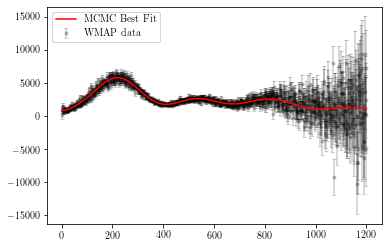

In [6]:
def gauss(p, mu, sigma):
    # simple gaussian distribution

    return (1.0/np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5*((p-mu)/sigma)**2)


# load opt results
popt = np.loadtxt("opt_params.txt")
pcov = np.loadtxt("opt_cov.txt")
popt_err = np.sqrt(np.diag(pcov))

# tunable_parameters
chainsdir = "mcmc3/"  # chains with a uniform prior on tau
addburn = 1000  # see problem 3 for the justification of 1000 burn in

# load chains
chains = np.loadtxt(chainsdir+"chains.txt")
chains = chains[addburn:]  # remove extra burn in
nsteps = chains.shape[0]
print("The chain has {} steps".format(nsteps))

# without weights (from 3)
pvals = np.median(chains, axis=0)  # get median for each param
perr_hi = np.percentile(chains, 84, axis=0) - pvals
perr_lo = pvals - np.percentile(chains, 16, axis=0)
perr = np.mean([perr_hi, perr_lo])

print()
# importance sample with Gaussian weigths
# we can use numpy to directly get parameters and uncertainties
weights = gauss(chains[:, 3], 0.0544, 0.0073)
pvals = np.average(chains, axis=0, weights=weights)
p_err = np.sqrt(np.diag(np.cov(chains, rowvar=False, aweights=weights, ddof=0)))
perr_hi = p_err.copy()
perr_lo = p_err.copy()

# print opt result
pnames = ["Ho", "ombh2", "omch2", "tau", "As", "ns"]
print("LMA Parameters:")
for i in range(len(popt)):
    if i == 4:
        print("  {} = {:.4f} +/- {:.4f}".format(pnames[i]+" x 10^9",
                                        popt[i]*10**9,
                                        np.sqrt(np.diag(pcov))[i]*10**9))
    else:
        print("  {} = {:.4f} +/- {:.4f}".format(pnames[i],
                                        popt[i],
                                        np.sqrt(np.diag(pcov))[i]))
print("Chi2:", chi2_opt)
print()

# MCMC with positive tau prior only
print("MCMC (+ve tau) parameters:")
for i in range(len(pvals3)):
    if i == 4:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i]+" x 10^9",
                                           pvals3[i]*10**9,
                                           perr3_hi[i]*10**9,
                                           perr3_lo[i]*10**9))
    else:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i],
                                           pvals3[i],
                                           perr3_hi[i],
                                           perr3_lo[i]))
print("Chi2:", chi2_mcmc3)
print()

# MCMC with prior parameters
print("MCMC (Gaussian prior) parameters:")
for i in range(len(pvals4)):
    if i == 4:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i]+" x 10^9",
                                           pvals4[i]*10**9,
                                           perr4_hi[i]*10**9,
                                           perr4_lo[i]*10**9))
    else:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i],
                                           pvals4[i],
                                           perr4_hi[i],
                                           perr4_lo[i]))
print("Chi2:", chi2_mcmc4)
print()
# Importance sampling
print("Parameters from importance sampling:")
for i in range(len(pvals)):
    if i == 4:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i]+" x 10^9",
                                           pvals[i]*10**9,
                                           perr_hi[i]*10**9,
                                           perr_lo[i]*10**9))
    else:
        print("  {} = {:.4f} + {:.4f} - {:.4f}".format(pnames[i],
                                           pvals[i],
                                           perr_hi[i],
                                           perr_lo[i]))
cmb_fit = get_spectrum(pvals)
chi2 = np.sum(((power - cmb_fit)/epower)**2)
print("Chi2:", chi2)

# plot final model
pl.spectrum(index, power, epower=epower, ind_fit=index, power_fit=cmb_fit,
            fit_label="MCMC Best Fit",
            savepath=chainsdir+"fit.png" if save else None)

As we see above the parameter values were consistent throughout the whole problem set. As noted before, the Gaussian prior on $\tau$ helped to reduce its errror as well as the error on the other parameters (especially $A_S$ because of the correlation). The importance sampling shows very similar value to MCMC with a Gaussian prior, as expected since they should be two ways of doing the same thing.